In [51]:
# Shanshank

from scipy.special import expit
import scipy.optimize
from scipy.optimize import minimize #, differential_evolution
import numpy as np
from math import sin,cos
#xarr=var('xarr')
x=np.linspace(0,2,11)
hvar=5
numeqs=4
omega=1.0
theta=1.0
bounds=np.zeros([3*4*5,2])
for i in range(3*4*5):
    bounds[i,0]=-5
    bounds[i,1]=5
partot=np.array(np.zeros(3*hvar*numeqs))
x0=[1.0,0.0,0.0,0.0]
#par = par.reshape(3,hvar)
print partot
print x
one=np.ones(hvar)

def sig(x,par):
    ans=[]
    par1 = par.reshape(3,hvar)
    #print "test", par[2]
    for i in x:
        ans.append(expit(i*par1[1,:]+par1[2,:]))
        #ans.append(np.tanh(i*par1[1,:]+par1[2,:]))
    return ans
def N(x,par):
    par1=par.reshape(3,hvar)
    ans=np.inner(par1[0,:],sig(x,par))
    return ans
def y(x,par,xini):
    return xini+x*N(x,par)
def dNdx(x,par):
    par1=par.reshape(3,hvar)
    ans=np.zeros(len(x))
    #print len(x)
    for j in range(len(x)):
        for i in range(hvar):
            ans[j]=ans[j]+(par1[0,i])*(sig(x,par)[j][i])*((one-sig(x,par))[j][i])*par1[1,i]
    return(ans)
def dydx(x,par):
    return N(x,par)+x*dNdx(x,par)
def yp(partot):
    partot1=partot.reshape((numeqs,3,hvar))
    cost=0.0
    cost=cost+np.sum(0.5*(dydx(x,partot1[0,:,:])-2*omega*sin(2*theta)*y(x,partot1[3,:,:],x0[3]))**2)
    cost=cost+np.sum(0.5*(dydx(x,partot1[1,:,:])+2*omega*sin(2*theta)*y(x,partot1[3,:,:],x0[3]))**2)
    cost=cost+np.sum(0.5*(dydx(x,partot1[2,:,:])-2*omega*cos(2*theta)*y(x,partot1[3,:,:],x0[3]))**2)
    cost=cost+np.sum(0.5*(dydx(x,partot1[3,:,:])+2*omega*cos(2*theta)*y(x,partot1[2,:,:],x0[2])+omega*sin(2*theta)*y(x,partot1[0,:,:],x0[0])-omega*sin(2*theta)*y(x,partot1[1,:,:],x0[1]))**2)
    cost=cost+np.sum((y(x,partot1[0,:,:],x0[0])+y(x,partot1[1,:,:],x0[1])-1.0)**2)
    return cost
#def ypprime(par): 
#vout=minimize(yp,par,method='COBYLA',options={"maxfev": 10000})
#vout=minimize(yp,partot,method='SLSQP',options={"maxiter": 1000})
#vout=minimize(yp,partot,method='Nelder-Mead',tol=1e-5,options={"ftol":1e-3, "maxfev": 1000000,"maxiter":1000000})
#vout=differential_evolution(yp,bounds,strategy='best1bin',tol=0.1,maxiter=1,polish=True)
#print vout


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2. ]


In [142]:
# Here is the activation function

def act(x):
    return expit(x)

# Density matrix in the forms that I wrote down on my Neutrino Physics notebook
# x is a real array of 12 arrays.

init = np.array([1.0,0.0,0.0,0.0])

def rho2(x,ti,initialCondition):
    
    elem = np.ones(4)
    
    for i in np.linspace(0,3,4):
        elem[i] = np.sum(ti*x[i*3]*act(ti*x[i*3+1] + x[i*3+2]) )
    
    return init + elem
    
# Hamiltonian of the problem, in terms of four real components

hamil = np.array( [  np.cos(2.0),np.sin(2.0) , np.sin(2.0),np.cos(2.0) ] )

# Cost function for each time step

def rhop(x,ti,initialCondition):
    
    rhoprime = np.zeros(4)
    
    for i in np.linspace(0,3,4):
        rhoprime[i] = np.sum(x[i*3] * (act(ti*x[i*3+1] + x[i*3+2]) ) ) +  np.sum( ti*x[i*3]* (act(ti*x[i*3+1] + x[i*3+2]) ) * (1.0 - (act(ti*x[i*3+1] + x[i*3+2])  ) )* x[i*3+1]  )
        
    return rhoprime


## This is the regularization

regularization = 0.0001

def costi(x,ti,initialCondition):
    
    rhoi = rho2(x,ti,initialCondition)
    rhopi = rhop(x,ti,initialCondition)
    
    costTemp = np.zeros(4)
    
    costTemp[0] = ( rhopi[0] - 2.0*rhoi[2]*hamil[1] )**2
    costTemp[1] = ( rhopi[1] - 2.0*rhoi[2]*hamil[0] )**2
    costTemp[2] = ( rhopi[2] + 2.0*rhoi[1]*hamil[0] - hamil[1] * (rhoi[3] - rhoi[0] ) )**2
    costTemp[3] = ( rhopi[3] + 2.0*rhoi[2]*hamil[1] )**2
    
    return np.sum(costTemp) + 2.0*(rhoi[0]+rhoi[3]-1.0)**2
    
#    return np.sum(costTemp) + regularization*np.sum(x**2)
    
def cost2(x,t,initialCondition):
    
    costTotal = map(lambda t: costi(x,t,initialCondition),t)
    
    return 0.5*np.sum(costTotal)

In [139]:
array12 = np.asarray(np.split(np.random.rand(1,60)[0],12))
ssfun11 = y(np.array([2.0]),array12.reshape((numeqs,3,hvar))[0,:,:],x0[0])
mifun11 = rho2(array12,2,init)[0]
print mifun11, ssfun11, ssfun11/mifun11 ## Good we have the same function values

3.88007648249 [ 3.88007648] [ 1.]


In [147]:
# rho prime
mirhop=rhop(array12,1,init)
ssrhop=dydx(x,array12.reshape((numeqs,3,hvar))[3,:,:])
print mirhop, ssrhop
## OK we have exactly the same rho prime.

[ 1.45321508  2.39720206  1.22168614  2.04320087] [ 1.63439549  1.73332522  1.82416417  1.90615056  1.97907901  2.04320087
  2.09909967  2.14756544  2.18948481  2.22575546  2.2572267 ]


In [161]:
mine = cost2(array12,x,init)
ss = yp(array12)
print mine, ss, ss/mine
#cost(xresult,np.array([0,4,11]),init)

364.343605924 542.797293181 1.48979502962


In [99]:
print hamil

[-0.41614684  0.90929743  0.90929743 -0.41614684]


In [113]:
np.cos(2)

-0.41614683654714241

In [162]:






# with ramdom initial guess

#initGuess = np.asarray(np.split(np.random.rand(1,60)[0],12))
initGuess = np.split(np.zeros(60),12)
endpoint = 6
tlin = np.linspace(0,endpoint,11)

costF = lambda x: cost2(x,tlin,init)

costvFResultSLSQP = minimize(costF,initGuess,method="SLSQP",tol=1e-20,options={"maxiter":10000})

print costvFResultSLSQP

  status: 0
 success: True
    njev: 500
    nfev: 31208
     fun: 0.31561053671243128
       x: array([ -8.38431710e+02,  -2.42466602e-01,  -7.77403939e+00,
         2.10453513e-01,  -5.16565187e+03,   9.30774208e+03,
        -6.75785974e+02,  -1.53377530e+00,  -6.76667377e+00,
         8.79796653e+02,  -2.42464335e-01,  -7.82221413e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00

[ 1.          0.97895255  0.95851891  0.93868566  0.91943963  0.90076794
  0.88265791  0.86509716  0.84807351  0.83157503  0.81559004  0.80010708
  0.7851149   0.77060248  0.75655903  0.74297396  0.72983689  0.71713764
  0.70486625  0.69301293  0.6815681   0.67052239  0.65986657  0.64959163
  0.63968873  0.63014921  0.62096458  0.61212651  0.60362686  0.59545763
  0.58761099  0.58007928  0.57285499  0.56593074  0.55929933  0.55295368
  0.54688688  0.54109214  0.53556282  0.5302924   0.52527453  0.52050294
  0.51597153  0.51167431  0.50760541  0.50375908  0.5001297   0.49671176
  0.49349987  0.49048874  0.4876732   0.48504819  0.48260875  0.48035002
  0.47826726  0.4763558   0.47461111  0.47302872  0.47160426  0.47033348
  0.46921218  0.46823628  0.46740178  0.46670476  0.46614139  0.46570791
  0.46540067  0.46521606  0.46515058  0.46520079  0.46536334  0.46563493
  0.46601235  0.46649245  0.46707216  0.46774848  0.46851845  0.46937921
  0.47032794  0.47136189  0.47247838  0.47367477  0

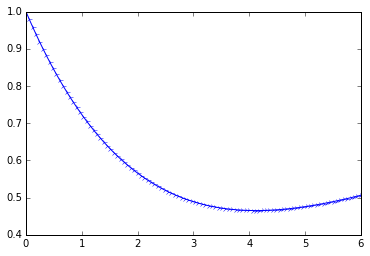

In [165]:
xresult = costvFResultSLSQP.get("x")
plttlin=np.linspace(0,endpoint,100)
pltdata11 = np.array([])
for i in plttlin:
    pltdata11 = np.append(pltdata11 ,(rho2(xresult,i,init)[0] ) )
    
print pltdata11
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()